In [1]:
# Aca resolvemos una ODE con condición inicial
# Problema 2 del articulo
# Artificial Neural Networks for Solving Ordinary and Partial Differential Equations

importamos los paquetes necesarios para el entrenamiento

In [2]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Donovan\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Se resuelve la ecuación diferencial 

\begin{align}
\frac{d}{dx}\psi_1 &= \cos(x) + \psi_1^2 + \psi_2 - (1 + x^2 + \sin^2(x)) \\
\frac{d}{dx}\psi_2 &= 2x - (1 + x^2)\sin(x) + \psi_1\psi_2
\end{align}

definición de la arquitectura de la red neuronal

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(1, 64)
        self.linear2 = nn.Linear(64, 124)
        self.linear3 = nn.Linear(124, 256)
        self.linear4 = nn.Linear(256, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        x = self.linear4(x)
        return x

Definición los modelos

In [4]:
N_1 = Model()
N_2 = Model()

Para

$\psi_{t_1}(x) = xN_1$

In [5]:
A_1 = 0
Psi_estimate_1 = lambda x: A_1 + x*N_1(x)


Para

$\psi_{t_2}(x) = 1 + xN_2$

In [6]:
A_2 = 1
Psi_estimate_2 = lambda x: A_2 + x*N_2(x)

In [7]:
# ahora definimos la función f(.)
f1 = lambda x, Psi_1, Psi_2: torch.cos(x) + Psi_1**2 + Psi_2 - (1 + x**2 + torch.sin(x)**2)
f2 = lambda x, Psi_1, Psi_2: 2*x - (1 + x**2)*torch.sin(x) + Psi_1*Psi_2

In [8]:
def loss(x):
    x.requires_grad = True
    outputs_1 = Psi_estimate_1(x)
    outputs_2 = Psi_estimate_2(x)
    Psi_estimate_x_1 = torch.autograd.grad(
                        outputs_1,x, 
                        grad_outputs=torch.ones_like(outputs_1),
                        create_graph=True)[0] # esta es la derivada de Psi con respecto a x, i.e., dPsi/dx
    Psi_estimate_x_2 = torch.autograd.grad(
                        outputs_2,x, 
                        grad_outputs=torch.ones_like(outputs_2)
                        ,create_graph=True)[0] # esta es la derivada de Psi con respecto a x, i.e., dPsi/dx
    return (torch.mean((Psi_estimate_x_1 - f1(x, outputs_1, outputs_2))**2) 
            + torch.mean((Psi_estimate_x_2 - f2(x, outputs_1, outputs_2))**2))


In [9]:
optimizer = torch.optim.Adam(list(N_1.parameters()) + list(N_2.parameters()), lr=0.01)

In [10]:
x = torch.Tensor(np.linspace(0,3,100)[:,None])

In [11]:
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l

for i in range(1000):
    optimizer.step(closure)

### Comparación de resultados

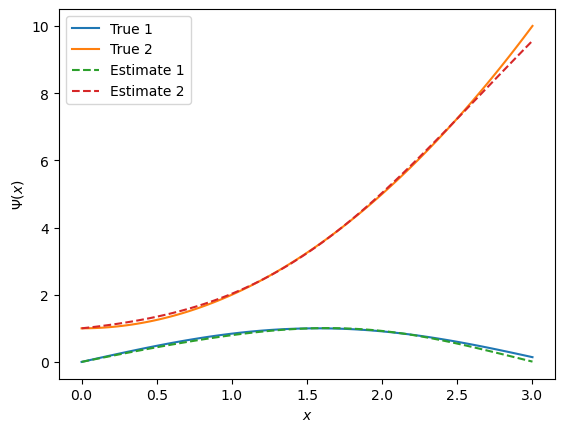

In [13]:
xx = np.linspace(0,3,100)[:,None]

with torch.no_grad():
    yy_1 = Psi_estimate_1(torch.Tensor(xx)).numpy()
    yy_2 = Psi_estimate_2(torch.Tensor(xx)).numpy()
    
yt_1 = np.sin(xx)
yt_2 = 1 + xx**2

fig, ax = plt.subplots(dpi=100)
ax.plot(xx,yt_1,label='True 1')
ax.plot(xx,yt_2,label='True 2')
ax.plot(xx,yy_1,'--',label='Estimate 1')
ax.plot(xx,yy_2,'--',label='Estimate 2')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best')